In [191]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [192]:
data = pd.read_csv("dataset.csv")
data.head()

,Unnamed: 0,X,ozone,radiation,temperature,wind
0,1,1,41,190,67,7.4
1,2,2,36,118,72,8.0
2,3,3,12,149,74,12.6
3,4,4,18,313,62,11.5
4,5,5,23,299,65,8.6


In [193]:
# first two columns are unnecessary (index)
data.drop(data.columns[[0, 1]], axis = 1, inplace = True)
data.head()

,ozone,radiation,temperature,wind
0,41,190,67,7.4
1,36,118,72,8.0
2,12,149,74,12.6
3,18,313,62,11.5
4,23,299,65,8.6


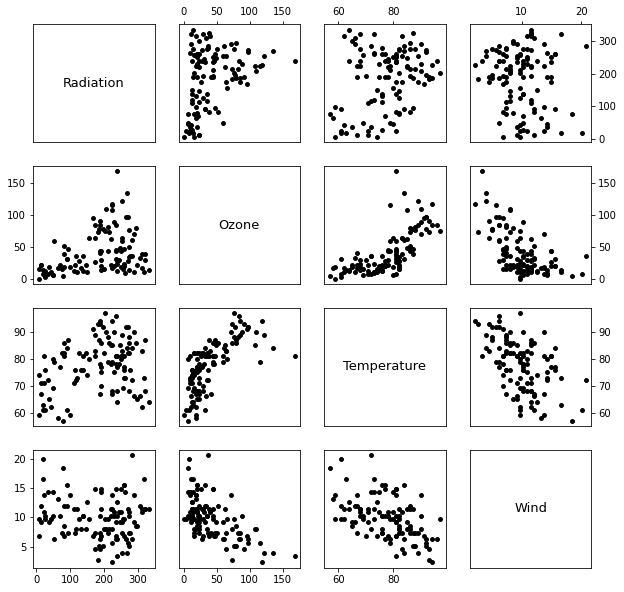

In [194]:
labels = ["radiation", "ozone", "temperature", "wind"]
fig, axs = plt.subplots(4, 4)
fig.set_size_inches(10, 10)
for i in range(4):
    for j in range(4):
        axs[i, j].axes.xaxis.set_visible(False)
        axs[i, j].axes.yaxis.set_visible(False)
        if i == j:
            axs[i, j].plot()
            axs[i, j].text(.5, .5, labels[i].capitalize(),  horizontalalignment='center', verticalalignment='center', transform=axs[i, j].transAxes, fontsize=13)
        else:
            if i == 0 or i == 3:
                axs[i, j].axes.xaxis.set_visible(True)
            if i == 0:
                axs[i, j].xaxis.tick_top()
            if j == 0 or j == 3:
                axs[i, j].axes.yaxis.set_visible(True)
            if j == 3:
                axs[i, j].yaxis.tick_right()
            axs[i, j].scatter(data[labels[j]], data[labels[i]], s=15, color="black")

In [195]:
X = data[["radiation", "temperature", "wind"]]
standarized_X = (X - X.mean()) / X.std()
Y = data[["ozone"]]

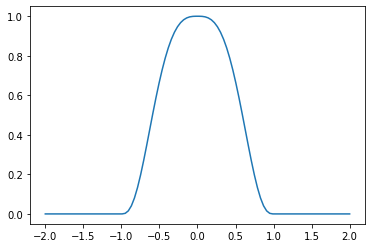

In [196]:
def tricubic(x):
    y = np.zeros_like(x)
    idx = (x >= -1) & (x <= 1)
    y[idx] = np.power(1.0 - np.power(np.abs(x[idx]), 3), 3)
    return y
plt.plot(np.linspace(-2, 2, 100), [tricubic(x) for x in np.linspace(-2, 2, 100)])

In [197]:
# q neighbors
# f = 0.4 
# q = int(f * len(data))
# res = []
# for i in range(len(data)):
#     # get q neareast neighbors
#     neighbors = X.iloc[np.argsort(np.linalg.norm(X - X.iloc[i], axis=1))[1:q+1]]

#     # weights
#     standarized_neighbors = (neighbors - neighbors.mean()) / neighbors.std()
#     distances = np.linalg.norm(standarized_neighbors - standarized_X.iloc[i], axis=1)
#     d = max(distances)
#     weights = np.array([tricubic(x / d) for x in distances])
#     W = np.diag(weights)
    
#     # solve normal equation
#     A = np.array(neighbors)
#     b = np.array(Y.iloc[neighbors.index])
#     x = np.linalg.inv(A.T @ W @ A) @ (A.T @ W @ b)
#     res.append(np.array(X.iloc[i]) @ x)

In [270]:
X = data[["radiation", "temperature", "wind"]]
standarized_X = (X - X.mean()) / X.std()
Y = data[["ozone"]]

In [271]:
# q neighbors
f = 0.4 
q = int(f * len(data))
res = []
for i in range(len(data)):
    # get q nearest neighbors
    distances = np.linalg.norm(standarized_X.iloc[i] - standarized_X, axis=1)
    neighbors = X.iloc[np.argsort(distances)[1:q+1]]
    distances = np.sort(distances)[1:q+1]

    # weights
    d = max(distances)
    weights = np.array([tricubic(i / d) for i in distances])
    W = np.diag(weights)

    # solve normal equation
    A = np.array(neighbors)
    b = np.array(Y.iloc[neighbors.index])
    x = np.linalg.inv(A.T @ W @ A) @ (A.T @ W @ b)
    res.append(np.array(X.iloc[i]) @ x)

In [272]:
data["prediction"] = np.array(res)
data["residual"] = data["ozone"] - data["prediction"]

Text(0, 0.5, 'Absolute Residuals')

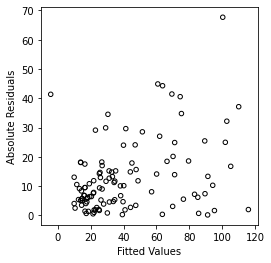

In [273]:
fig, ax = plt.subplots()
ax.set_box_aspect(1)
plt.scatter(data["prediction"], abs(data["residual"]), facecolors='none', edgecolors='black', s=20)
plt.xlabel("Fitted Values")
plt.ylabel("Absolute Residuals")

Text(0, 0.5, 'Residuals')

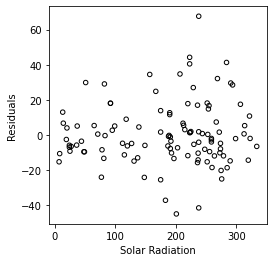

In [274]:
fig, ax = plt.subplots()
ax.set_box_aspect(1)
plt.scatter(data["radiation"], data["residual"], facecolors='none', edgecolors='black', s=20)
plt.xlabel("Solar Radiation")
plt.ylabel("Residuals")

Text(0, 0.5, 'Residuals')

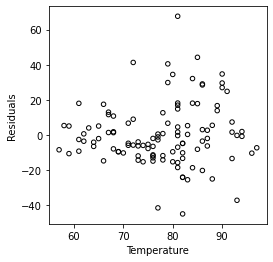

In [276]:
fig, ax = plt.subplots()
ax.set_box_aspect(1)
plt.scatter(data["temperature"], data["residual"], facecolors='none', edgecolors='black', s=20)
plt.xlabel("Temperature")
plt.ylabel("Residuals")

Text(0, 0.5, 'Residuals')

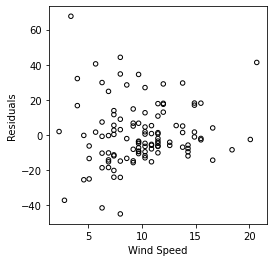

In [278]:
fig, ax = plt.subplots()
ax.set_box_aspect(1)
plt.scatter(data["wind"], data["residual"], facecolors='none', edgecolors='black', s=20)
plt.xlabel("Wind Speed")
plt.ylabel("Residuals")